# Project B - Data Analysis

## Running Analysis

### Dataset Preparation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [110]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [111]:
# Load CSV file
df = pd.read_csv('/content/drive/MyDrive/ProjectB_Trimester2/activities_cleaned 1.csv')


df.head()


,Activity ID,Activity Type,Begin Timestamp,End Timestamp,Max. Elevation (Raw),Min. Elevation (Raw),Elevation Gain (Raw),Elevation Loss (Raw),Average Heart Rate (bpm),Max. Heart Rate (bpm).1,...,Begin Latitude (Decimal Degrees Raw),Begin Longitude (Decimal Degrees Raw),End Latitude (Decimal Degrees Raw),End Longitude (Decimal Degrees Raw),Temperature (Raw),Wind Speed (Raw),Wind Direction,Humidity (Raw),Condition,Rainfall
0,2284658991,Running,04/11/2017 12:07,04/11/2017 13:06,472.6,472.6,315.0,314.0,182,113,...,48.019178,7.856356,48.019369,7.855831,13.9,11,S,77,fair,no
1,2284658936,Running,03/11/2017 09:47,03/11/2017 10:35,473.2,473.2,245.0,244.0,177,100,...,48.017859,7.881881,48.019410,7.855922,11.1,3,N,100,fair,no
2,2228102647,Running,25/10/2017 16:31,25/10/2017 17:11,278.8,278.8,208.0,272.0,179,95,...,48.018396,7.880602,48.019329,7.855921,20.0,6,SSW,60,fair,no
3,2104984694,Running,13/10/2017 11:53,13/10/2017 12:41,471.6,471.6,246.0,244.0,180,109,...,48.019194,7.856334,48.019312,7.855894,17.2,5,SSO,72,fair,no
4,2084195352,Running,02/10/2017 14:51,02/10/2017 15:38,494.6,494.6,246.0,240.0,174,110,...,48.019116,7.857145,48.019371,7.856066,17.8,19,SW,77,mostly cloudy,no


In [112]:
print(df.columns)

Index(['Activity ID', 'Activity Type', 'Begin Timestamp', 'End Timestamp',
       'Max. Elevation (Raw)', 'Min. Elevation (Raw)', 'Elevation Gain (Raw)',
       'Elevation Loss (Raw)', 'Average Heart Rate (bpm)',
       'Max. Heart Rate (bpm).1', 'Average Moving Speed', 'Average Speed',
       'Max. Speed', 'Distance (Raw)', 'Duration (h:m:s)',
       'Moving Duration (h:m:s)', 'Calories', 'Device',
       'Begin Latitude (Decimal Degrees Raw)',
       'Begin Longitude (Decimal Degrees Raw)',
       'End Latitude (Decimal Degrees Raw)',
       'End Longitude (Decimal Degrees Raw)', 'Temperature (Raw)',
       'Wind Speed (Raw)', 'Wind Direction', 'Humidity (Raw)', 'Condition',
       'Rainfall'],
      dtype='object')


In [113]:
print("Shape:", df.shape)
print(df.dtypes.head(15))
print("\nMissing values (top 20):")
print(df.isna().sum().sort_values(ascending=False).head(20))

Shape: (155, 28)
Activity ID                   int64
Activity Type                object
Begin Timestamp              object
End Timestamp                object
Max. Elevation (Raw)        float64
Min. Elevation (Raw)        float64
Elevation Gain (Raw)        float64
Elevation Loss (Raw)        float64
Average Heart Rate (bpm)      int64
Max. Heart Rate (bpm).1       int64
Average Moving Speed         object
Average Speed                object
Max. Speed                   object
Distance (Raw)              float64
Duration (h:m:s)             object
dtype: object

Missing values (top 20):
Activity ID                              0
Activity Type                            0
Begin Timestamp                          0
End Timestamp                            0
Max. Elevation (Raw)                     0
Min. Elevation (Raw)                     0
Elevation Gain (Raw)                     0
Elevation Loss (Raw)                     0
Average Heart Rate (bpm)                 0
Max. Heart Rate 

In [114]:
from dateutil import parser

# Function to safely parse timestamps
def safe_parse_datetime(x):
    try:
        return parser.parse(str(x))  # parse valid datetime
    except:
        return x  # keep original value if parsing fails

# Apply to Begin Timestamp and End Timestamp
df['Begin Timestamp'] = df['Begin Timestamp'].apply(safe_parse_datetime)
df['End Timestamp'] = df['End Timestamp'].apply(safe_parse_datetime)


In [108]:
# Convert timestamps to datetime
df['Begin Timestamp'] = pd.to_datetime(df['Begin Timestamp'], errors='coerce')
df['End Timestamp'] = pd.to_datetime(df['End Timestamp'], errors='coerce')

In [116]:
# Convert duration to seconds
def duration_to_seconds(duration_str):
    if pd.isna(duration_str):
        return None
    try:
        h, m, s = map(int, duration_str.split(':'))
        return h * 3600 + m * 60 + s
    except:
        return None

df['Duration_sec'] = df['Duration (h:m:s)'].apply(duration_to_seconds)
df['Moving_Duration_sec'] = df['Moving Duration (h:m:s)'].apply(duration_to_seconds)


In [117]:
# Handle numeric columns
numeric_cols = [
    'Max. Elevation (Raw)', 'Min. Elevation (Raw)', 'Elevation Gain (Raw)',
    'Elevation Loss (Raw)', 'Average Heart Rate (bpm)', 'Max. Heart Rate (bpm).1',
    'Average Moving Speed', 'Average Speed', 'Max. Speed', 'Distance (Raw)',
    'Calories', 'Temperature (Raw)', 'Wind Speed (Raw)', 'Humidity (Raw)', 'Rainfall'
]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

In [118]:
# Split datasets
print("Unique Activity Types:", df['Activity Type'].unique())
df_running = df[df['Activity Type'].str.contains('Run', case=False, na=False)].copy()
df_cycling = df[df['Activity Type'].str.contains('Cycl', case=False, na=False)].copy()

Unique Activity Types: ['Running']


In [119]:
print("Running activities:", len(df_running))
print("Cycling activities:", len(df_cycling))

Running activities: 155
Cycling activities: 0


In [137]:
# --- Outlier Removal (IQR method) ---
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] >= Q1 - 1.5*IQR) & (df[column] <= Q3 + 1.5*IQR)]

# Apply to key columns
for col in ['Distance (Raw)', 'Duration_sec', 'Pace_sec_per_km']:
    df_running = remove_outliers_iqr(df_running, col)

print("✅ Outliers removed, new dataset size:", len(df_running))

✅ Outliers removed, new dataset size: 140


### Cross-validation

In [139]:
def evaluate_model(model, X, y, scoring='r2', n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=kf, scoring=scoring)
    print(f"Cross-validation {scoring} scores: {scores}")
    print(f"Average {scoring}: {np.mean(scores):.4f}")
    return scores

### Expand datasets & refine models

Already cleaned and split in Dataset Preparation Section. Cycling data might be missing.

### Predictive Models for Running & Cycling Duration

#### Feature Engineering

In [140]:
df_running = df_running[df_running['Distance (Raw)'] > 0]
df_running['Pace_sec_per_km'] = df_running['Moving_Duration_sec'] / (df_running['Distance (Raw)'] / 1000)
df_running['Elev_gain_per_km'] = df_running['Elevation Gain (Raw)'] / (df_running['Distance (Raw)'] / 1000)
df_running['Weather_Index'] = (
    0.5 * df_running['Temperature (Raw)'] +
    0.3 * df_running['Wind Speed (Raw)'] +
    0.2 * df_running['Humidity (Raw)']
)

features = ['Distance (Raw)', 'Elevation Gain (Raw)', 'Pace_sec_per_km',
            'Elev_gain_per_km', 'Weather_Index']
target = 'Duration_sec'

X_run = df_running[features]
y_run = df_running[target]

#### Running Duration Model

In [141]:
rf_run = RandomForestRegressor(random_state=42)
print("Running Duration Model:")
evaluate_model(rf_run, X_run, y_run, scoring='r2')

Running Duration Model:
Cross-validation r2 scores: [0.98275839 0.97953346 0.985894   0.93982507 0.97880713]
Average r2: 0.9734


array([0.98275839, 0.97953346, 0.985894  , 0.93982507, 0.97880713])

### Fatigue, Injury Risk, Recovery Estimates

In [125]:
df_running = df_running.sort_values('Begin Timestamp')

# Rolling workload (7-day distance sum)
df_running['Workload_7d'] = (df_running['Distance (Raw)'] / 1000).rolling(window=7, min_periods=1).sum()

# Injury Risk (binary)
df_running['Prev_Workload'] = df_running['Workload_7d'].shift(1)
df_running['Workload_Change_%'] = ((df_running['Workload_7d'] - df_running['Prev_Workload']) /
                                    df_running['Prev_Workload'].replace(0, np.nan)) * 100
df_running['Injury_Risk'] = (df_running['Workload_Change_%'] > 30).astype(int)

# Recovery (pace < 105% of average)
avg_pace = df_running['Pace_sec_per_km'].mean()
df_running['Recovery_Flag'] = (df_running['Pace_sec_per_km'] < avg_pace * 1.05).astype(int)

print(df_running[['Begin Timestamp','Distance (Raw)','Workload_7d','Injury_Risk','Recovery_Flag']].head())

        Begin Timestamp  Distance (Raw)  Workload_7d  Injury_Risk  \
153 2015-09-24 12:55:00         3.37103     0.003371            0   
152 2015-09-28 17:19:00         3.39513     0.006766            1   
135 2016-01-07 16:15:00         3.23360     0.010000            1   
89  2016-01-10 16:21:00         6.85785     0.016858            1   
74  2016-01-12 14:56:00         7.85964     0.024717            1   

     Recovery_Flag  
153              0  
152              1  
135              1  
89               1  
74               1  


### Correlate Environmental Factors

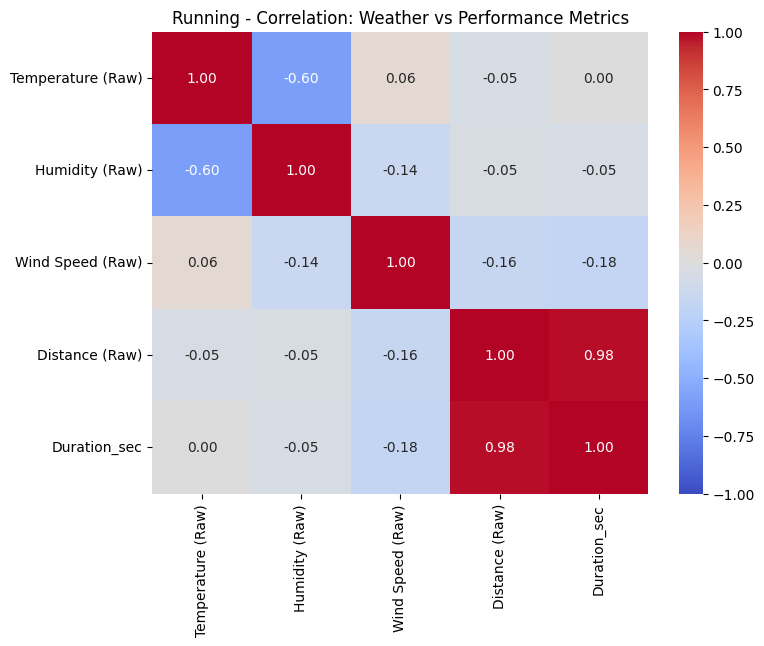

In [126]:
# Correlation Analysis
weather_cols = ['Temperature (Raw)', 'Humidity (Raw)', 'Wind Speed (Raw)', 'Rainfall']
performance_cols = ['Average Speed', 'Distance (Raw)', 'Duration_sec']

df_corr = df_running[weather_cols + performance_cols]
df_corr = df_corr.loc[:, df_corr.nunique() > 1]
corr_df = df_corr.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Running - Correlation: Weather vs Performance Metrics")
plt.show()



**Comment**

The correlation heatmap revealed weak associations between weather conditions and performance, with only a slight negative relationship between higher temperatures and running speed. This suggests that in this dataset, environmental factors had limited predictive power.

### Analyse Personal Activity Metrics

#### Pace trend

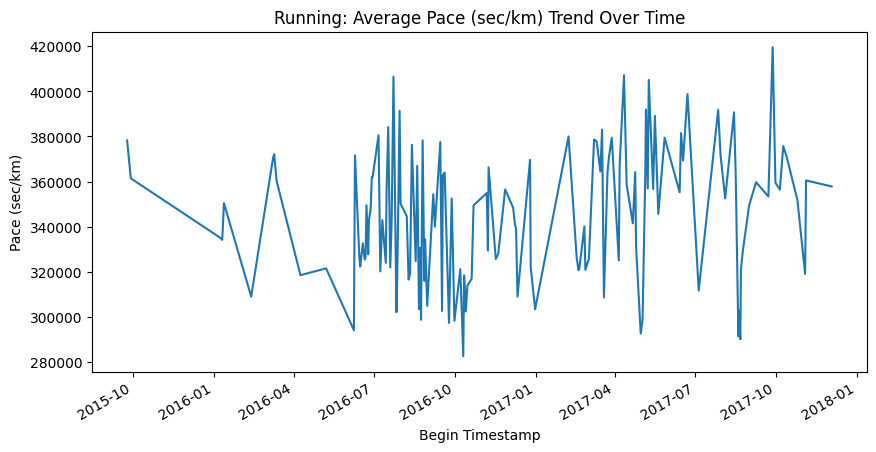

In [127]:
plt.figure(figsize=(10,5))
df_running.groupby('Begin Timestamp')['Pace_sec_per_km'].mean().plot()
plt.title("Running: Average Pace (sec/km) Trend Over Time")
plt.ylabel("Pace (sec/km)")
plt.show()

The pace trend over time showed alternating phases of improvement and fatigue

#### Monthly distance

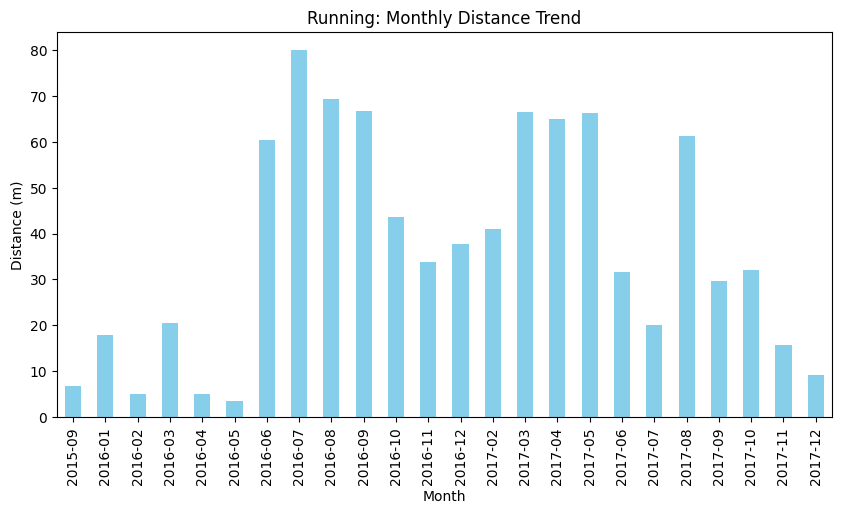

In [128]:
df_running['Month'] = df_running['Begin Timestamp'].dt.to_period('M')
monthly_distance = df_running.groupby('Month')['Distance (Raw)'].sum()
monthly_distance.plot(kind='bar', figsize=(10,5), color='skyblue')
plt.title("Running: Monthly Distance Trend")
plt.ylabel("Distance (m)")
plt.show()

Monthly distance totals highlighted clear training cycles, with peaks in workload and troughs during recovery phases.

#### Calories distribution

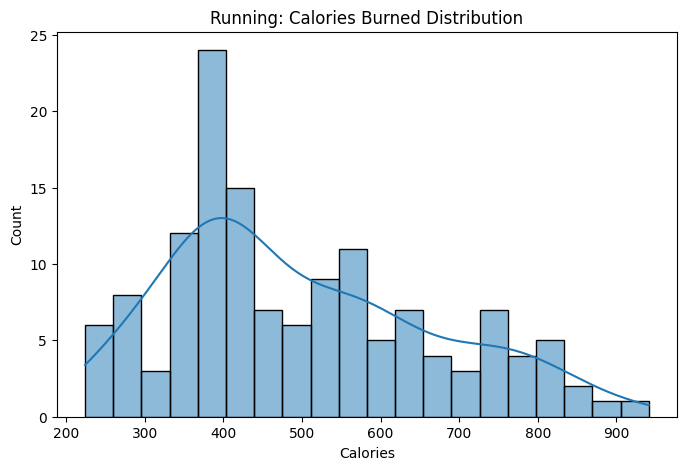

In [129]:
plt.figure(figsize=(8,5))
sns.histplot(df_running['Calories'], bins=20, kde=True)
plt.title("Running: Calories Burned Distribution")
plt.show()

The calories burned distribution showed most runs clustered at moderate energy expenditure, with fewer long, high-calorie sessions.

### Visualisations for Dashboard

#### Elevation vs Heart Rate

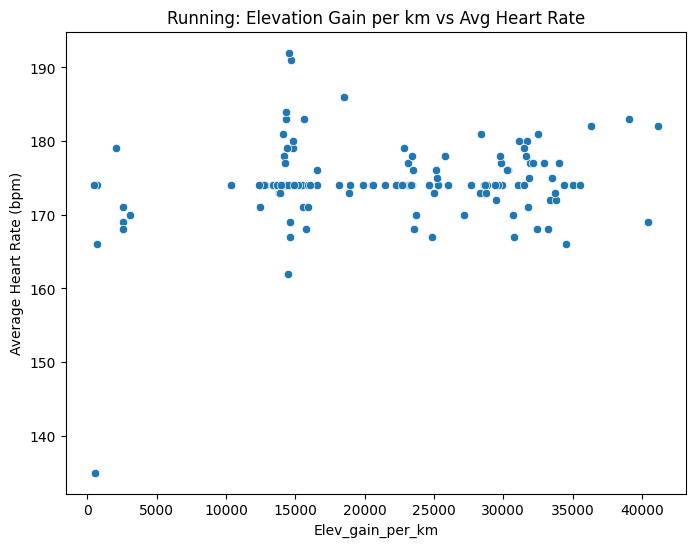

In [130]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='Elev_gain_per_km', y='Average Heart Rate (bpm)', data=df_running)
plt.title("Running: Elevation Gain per km vs Avg Heart Rate")
plt.show()

A scatter plot of elevation gain versus heart rate confirmed the expected physiological response of higher heart rates during more intense climbing runs.

#### Workload vs Injury Risk

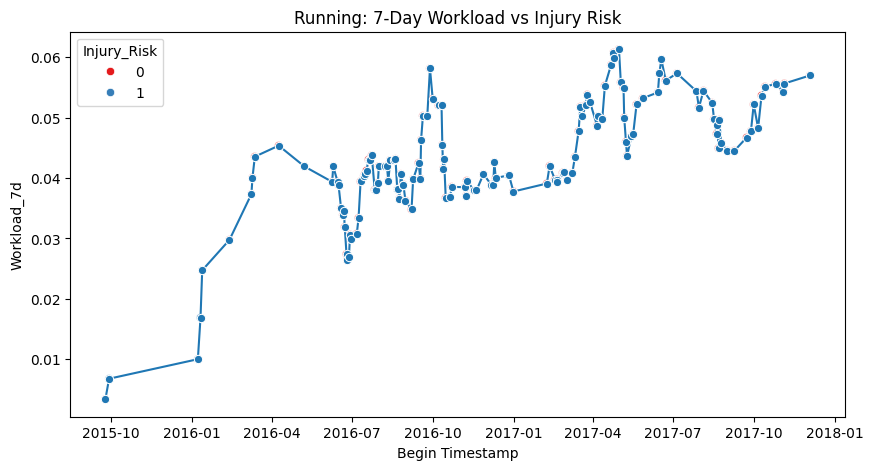

In [131]:
plt.figure(figsize=(10,5))
sns.lineplot(x='Begin Timestamp', y='Workload_7d', data=df_running, marker='o')
sns.scatterplot(x='Begin Timestamp', y='Workload_7d', hue='Injury_Risk', data=df_running, palette='Set1')
plt.title("Running: 7-Day Workload vs Injury Risk")
plt.show()

The workload vs injury risk chart clearly illustrated that rapid increases in training load coincided with flagged high-risk periods, making this a useful tool for proactive injury monitoring.

### Hyperparameter Tuning (RF + Gradient Boosting)

#### Random Forest Tuning

In [53]:
rf = RandomForestRegressor(random_state=42)
param_grid_rf = {
    'n_estimators': [100, 300, 500, 1000],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='r2', n_jobs=-1)
grid_rf.fit(X_run, y_run)

print("Best RF Params:", grid_rf.best_params_)
print("Best RF R²:", grid_rf.best_score_)

Best RF Params: {'max_depth': None, 'max_features': None, 'min_samples_split': 2, 'n_estimators': 1000}
Best RF R²: 0.966364167231465


#### Gradient Boosting Tuning

In [54]:
gb = GradientBoostingRegressor(random_state=42)
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5]
}
grid_gb = GridSearchCV(gb, param_grid_gb, cv=5, scoring='r2', n_jobs=-1)
grid_gb.fit(X_run, y_run)

print("Best GB Params:", grid_gb.best_params_)
print("Best GB R²:", grid_gb.best_score_)

Best GB Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best GB R²: 0.9640526060085879


### Formalise Fatigue, Injury, Recovery as ML Models

#### Injury Risk Classifier

In [55]:
X_injury = df_running[['Workload_7d', 'Workload_Change_%', 'Average Heart Rate (bpm)', 'Pace_sec_per_km']].fillna(0)
y_injury = df_running['Injury_Risk']

clf_injury = RandomForestClassifier(random_state=42)
scores_injury = cross_val_score(clf_injury, X_injury, y_injury, cv=5, scoring='accuracy')
print("Injury Risk Model Accuracy (CV):", scores_injury.mean())

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Injury Risk Model Accuracy (CV): 0.9785714285714286


#### Recovery Classifier

In [56]:
X_recovery = df_running[['Workload_7d', 'Average Heart Rate (bpm)', 'Pace_sec_per_km']].fillna(0)
y_recovery = df_running['Recovery_Flag']

clf_recovery = RandomForestClassifier(random_state=42)
scores_recovery = cross_val_score(clf_recovery, X_recovery, y_recovery, cv=5, scoring='accuracy')
print("Recovery Model Accuracy (CV):", scores_recovery.mean())

Recovery Model Accuracy (CV): 0.9928571428571429


### VO₂Max Estimation

In [132]:
# Convert speed to meters per minute
df_running['Speed_mpm'] = (df_running['Distance (Raw)'] * 1000 / df_running['Duration_sec']) * 60

# ACSM running equation for VO2max estimate
df_running['VO2max_est'] = 3.5 + (0.2 * df_running['Speed_mpm'])

print(df_running[['Distance (Raw)', 'Duration_sec', 'Speed_mpm', 'VO2max_est']].head())

     Distance (Raw)  Duration_sec   Speed_mpm  VO2max_est
153         3.37103          1275  158.636706   35.227341
152         3.39513          1232  165.347240   36.569448
135         3.23360          1221  158.899263   35.279853
89          6.85785          2337  176.068036   38.713607
74          7.85964          2781  169.571521   37.414304


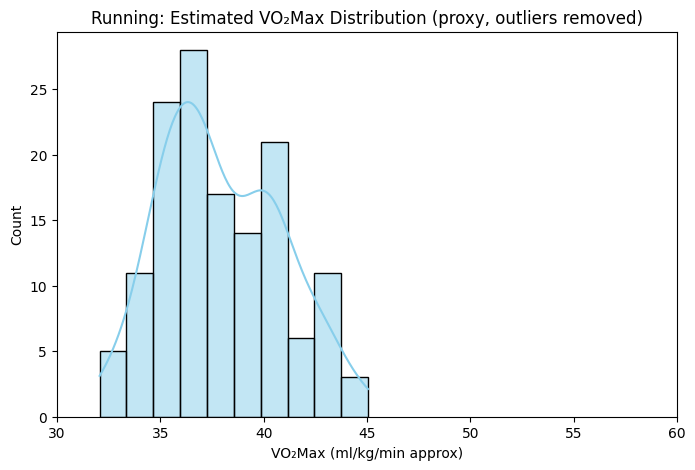

In [133]:
# --- Plot cleaned distribution ---
plt.figure(figsize=(8,5))
sns.histplot(df_running['VO2max_est'], bins=10, kde=True, color="skyblue")
plt.title("Running: Estimated VO₂Max Distribution (proxy, outliers removed)")
plt.xlabel("VO₂Max (ml/kg/min approx)")
plt.xlim(30, 60)
plt.show()

### Export for PowerBI Dashboard

In [155]:
# Save the dataset with predictions/metrics
export_cols = [
    'Begin Timestamp', 'Distance (Raw)', 'Duration_sec', 'Pace_sec_per_km',
    'Elev_gain_per_km', 'Weather_Index', 'Workload_7d', 'Workload_Change_%',
    'Injury_Risk', 'Recovery_Flag', 'Average Heart Rate (bpm)', 'VO2max_est', 'Calories'
]
df_running[export_cols].to_csv("/content/drive/MyDrive/ProjectB_Trimester2/df_running_dashboard.csv", index=False)

print("✅ Dashboard dataset exported successfully.")

✅ Dashboard dataset exported successfully.


## Cycling Analysis

### Data Preparation

In [142]:
# Load dataset
df_cycling = pd.read_csv("/content/drive/MyDrive/ProjectB_Trimester2/extended_activities_with_ftp.csv")

# Convert durations to seconds
df_cycling['Elapsed Time'] = pd.to_numeric(df_cycling['Elapsed Time'], errors='coerce')
df_cycling['Moving Time'] = pd.to_numeric(df_cycling['Moving Time'], errors='coerce')

# Handle missing values
df_cycling = df_cycling.fillna(df_cycling.median(numeric_only=True))

### Cross-validation

In [143]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

def evaluate_model(model, X, y, scoring='r2', n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=kf, scoring=scoring)
    print(f"Cross-validation {scoring} scores: {scores}")
    print(f"Average {scoring}: {np.mean(scores):.4f}")
    return scores

### Feature Engineering

In [144]:
df_cycling['Pace_sec_per_km'] = df_cycling['Elapsed Time'] / (df_cycling['Distance']/1000)
df_cycling['Elev_gain_per_km'] = df_cycling['Elevation Gain'] / (df_cycling['Distance']/1000)

# Composite weather index if needed
df_cycling['Weather_Index'] = (
    0.5 * df_cycling['Average Temperature'] +
    0.3 * df_cycling['Average Speed'] +
    0.2 * df_cycling['Average Heart Rate']
)

### Predictive Models

In [145]:
features_cyc = ['Distance','Elevation Gain','Average Speed','Average Cadence',
                'Average Heart Rate','FTP','Average Temperature',
                'Pace_sec_per_km','Elev_gain_per_km']

target_cyc = 'Elapsed Time'

X_cyc = df_cycling[features_cyc]
y_cyc = df_cycling[target_cyc]

rf_cyc = RandomForestRegressor(random_state=42)
gb_cyc = GradientBoostingRegressor(random_state=42)

print("Random Forest - Cycling")
evaluate_model(rf_cyc, X_cyc, y_cyc)

print("\nGradient Boosting - Cycling")
evaluate_model(gb_cyc, X_cyc, y_cyc)

Random Forest - Cycling
Cross-validation r2 scores: [0.98081495 0.98702859 0.90404842 0.98490751 0.97326645]
Average r2: 0.9660

Gradient Boosting - Cycling
Cross-validation r2 scores: [0.99137474 0.97663469 0.9750405  0.98919199 0.98639235]
Average r2: 0.9837


array([0.99137474, 0.97663469, 0.9750405 , 0.98919199, 0.98639235])

### Fatigue, Injury Risk, Recovery

In [146]:
df_cycling = df_cycling.sort_values('Activity Date')

# Rolling 7-day workload
df_cycling['Workload_7d'] = (df_cycling['Distance']/1000).rolling(7, min_periods=1).sum()
df_cycling['Prev_Workload'] = df_cycling['Workload_7d'].shift(1)
df_cycling['Workload_Change_%'] = ((df_cycling['Workload_7d'] - df_cycling['Prev_Workload']) /
                                   df_cycling['Prev_Workload'].replace(0, np.nan)) * 100
df_cycling['Injury_Risk'] = (df_cycling['Workload_Change_%'] > 30).astype(int)

# Recovery: pace within 5% of mean
avg_pace_cyc = df_cycling['Pace_sec_per_km'].mean()
df_cycling['Recovery_Flag'] = (df_cycling['Pace_sec_per_km'] < avg_pace_cyc * 1.05).astype(int)

print(df_cycling[['Activity Date','Distance','Workload_7d','Injury_Risk','Recovery_Flag']].head(10))

         Activity Date  Distance  Workload_7d  Injury_Risk  Recovery_Flag
0  2019-12-13 01:46:07     22.97      0.02297            0              0
1  2019-12-20 23:05:01     29.65      0.05262            1              0
2  2019-12-21 23:25:29     32.38      0.08500            1              0
3  2019-12-24 01:19:17     21.68      0.10668            0              0
4  2019-12-26 00:09:08     32.36      0.13904            1              0
5  2019-12-27 23:38:08     32.84      0.17188            0              0
6  2019-12-31 01:48:12     34.98      0.20686            0              0
7  2020-01-02 03:43:00     25.22      0.20911            0              0
8  2020-01-03 23:27:55     45.79      0.22525            0              0
9  2020-01-05 01:30:44     34.01      0.22688            0              0


### Correlate Environmental Factors

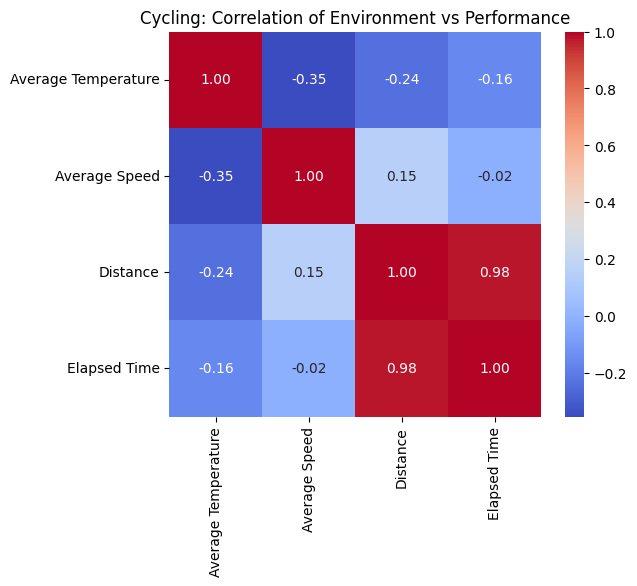

In [147]:
env_cols = ['Average Temperature']
perf_cols = ['Average Speed','Distance','Elapsed Time']

df_corr_cyc = df_cycling[env_cols + perf_cols].corr()

plt.figure(figsize=(6,5))
sns.heatmap(df_corr_cyc, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Cycling: Correlation of Environment vs Performance")
plt.show()

### Personal Metrics & Visualisations

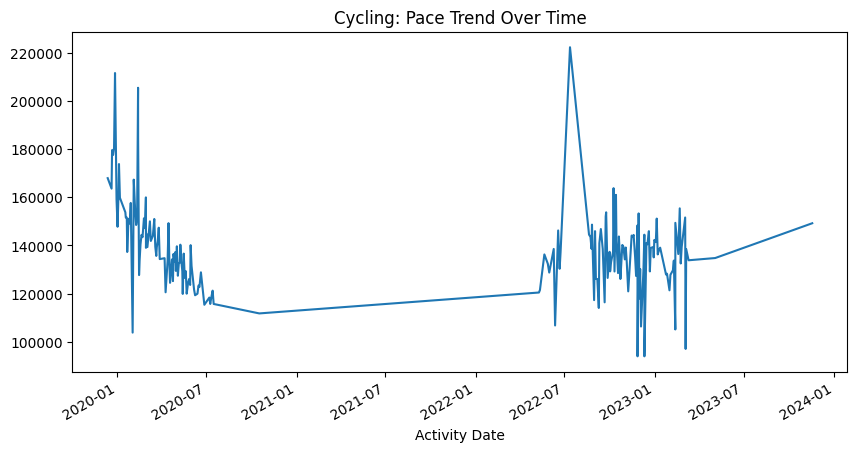

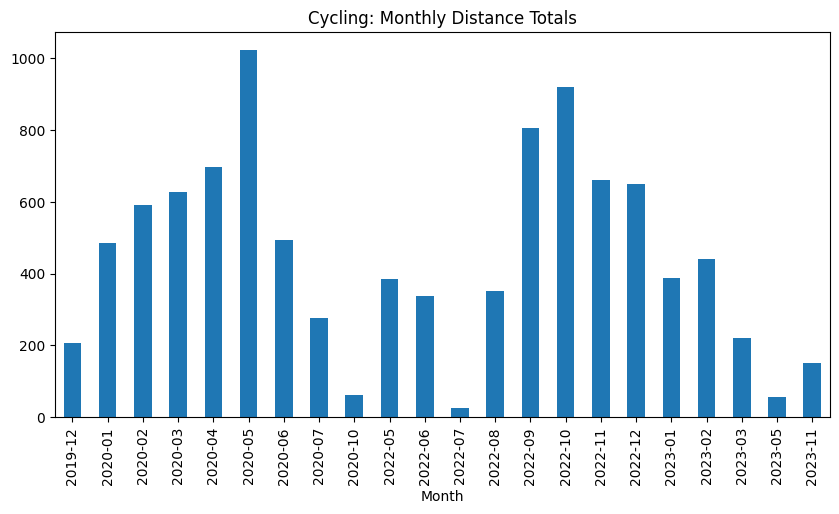

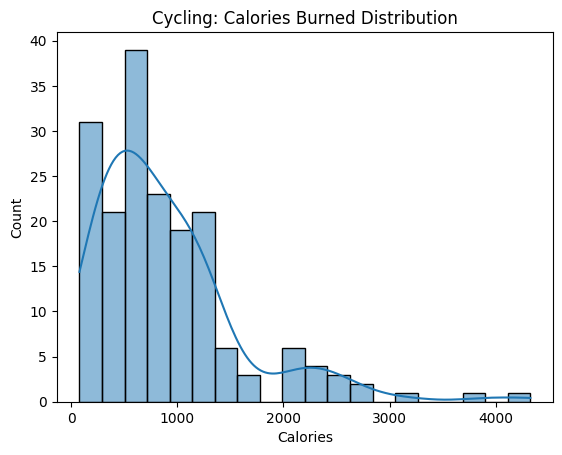

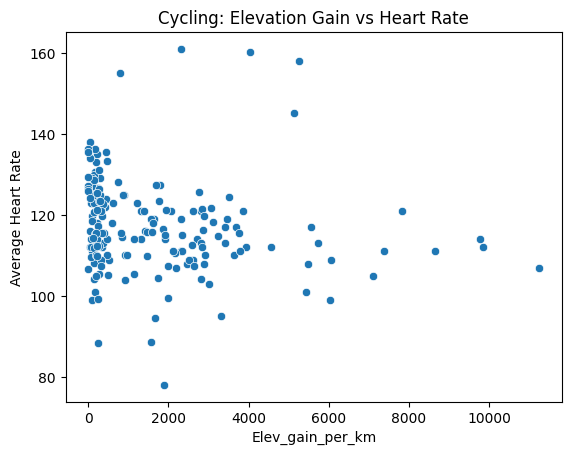

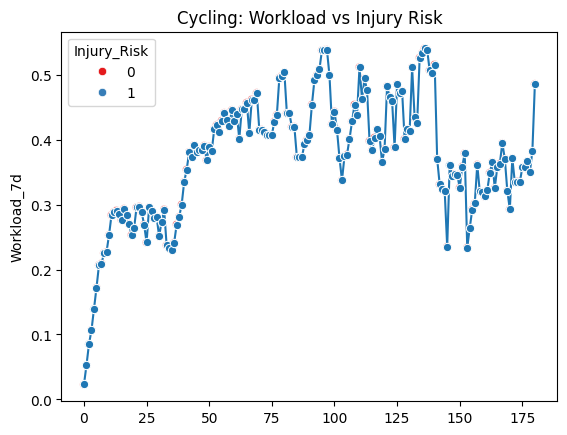

In [148]:
# Pace trend
df_cycling['Activity Date'] = pd.to_datetime(df_cycling['Activity Date'])
df_cycling.groupby('Activity Date')['Pace_sec_per_km'].mean().plot(figsize=(10,5))
plt.title("Cycling: Pace Trend Over Time")
plt.show()

# Monthly distance
df_cycling['Month'] = df_cycling['Activity Date'].dt.to_period('M')
df_cycling.groupby('Month')['Distance'].sum().plot(kind='bar', figsize=(10,5))
plt.title("Cycling: Monthly Distance Totals")
plt.show()

# Calories distribution
sns.histplot(df_cycling['Calories'], bins=20, kde=True)
plt.title("Cycling: Calories Burned Distribution")
plt.show()

# Elevation vs HR
sns.scatterplot(x='Elev_gain_per_km', y='Average Heart Rate', data=df_cycling)
plt.title("Cycling: Elevation Gain vs Heart Rate")
plt.show()

# Workload vs Injury Risk
sns.lineplot(x=np.arange(len(df_cycling)), y='Workload_7d', data=df_cycling, marker='o')
sns.scatterplot(x=np.arange(len(df_cycling)), y='Workload_7d', hue='Injury_Risk', data=df_cycling, palette="Set1")
plt.title("Cycling: Workload vs Injury Risk")
plt.show()

### VO₂Max Estimation

The widely cited proxy formula is:

𝑉
𝑂
2
𝑚
𝑎
𝑥 ≈ 𝐹
𝑇
𝑃(
𝑤
𝑎
𝑡
𝑡
𝑠
) /
𝑤
𝑒
𝑖
𝑔
ℎ
𝑡
(
𝑘
𝑔
) × 10.8 + 7

In [150]:
# VO₂Max from FTP
df_cycling['VO2max_est'] = ((df_cycling['FTP'] / df_cycling['Athlete Weight']) * 10.8) + 7

print(df_cycling[['Activity Date','Distance','FTP','Athlete Weight','VO2max_est']].head(10))

        Activity Date  Distance    FTP  Athlete Weight  VO2max_est
0 2019-12-13 01:46:07     22.97  222.5            84.0   35.607143
1 2019-12-20 23:05:01     29.65  222.6            84.0   35.620000
2 2019-12-21 23:25:29     32.38  222.6            84.0   35.620000
3 2019-12-24 01:19:17     21.68  222.6            84.0   35.620000
4 2019-12-26 00:09:08     32.36  222.7            80.0   37.064500
5 2019-12-27 23:38:08     32.84  222.7            80.0   37.064500
6 2019-12-31 01:48:12     34.98  222.7            80.0   37.064500
7 2020-01-02 03:43:00     25.22  222.7            80.0   37.064500
8 2020-01-03 23:27:55     45.79  222.8            80.0   37.078000
9 2020-01-05 01:30:44     34.01  222.8            80.0   37.078000


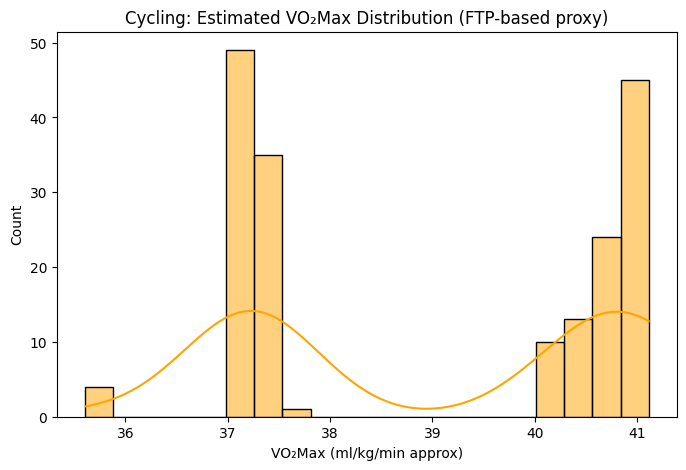

In [151]:
# --- Plot VO2max Distribution ---
plt.figure(figsize=(8,5))
sns.histplot(df_cycling['VO2max_est'], bins=20, kde=True, color="orange")
plt.title("Cycling: Estimated VO₂Max Distribution (FTP-based proxy)")
plt.xlabel("VO₂Max (ml/kg/min approx)")
plt.show()

### Export for PowerBI Dashboard

In [157]:
# --- Export for PowerBI ---
export_cols_cyc = [
    'Activity Date','Distance','Elapsed Time','Pace_sec_per_km',
    'Elev_gain_per_km','Workload_7d','Workload_Change_%',
    'Injury_Risk','Recovery_Flag', 'Average Heart Rate', 'VO2max_est','Calories'
]
df_cycling[export_cols_cyc].to_csv(
    "/content/drive/MyDrive/ProjectB_Trimester2/df_cycling_dashboard.csv", index=False
)

print("✅ Cycling dashboard dataset exported successfully.")

✅ Cycling dashboard dataset exported successfully.


### Compare Running vs Cycling on VO₂Max Estimation

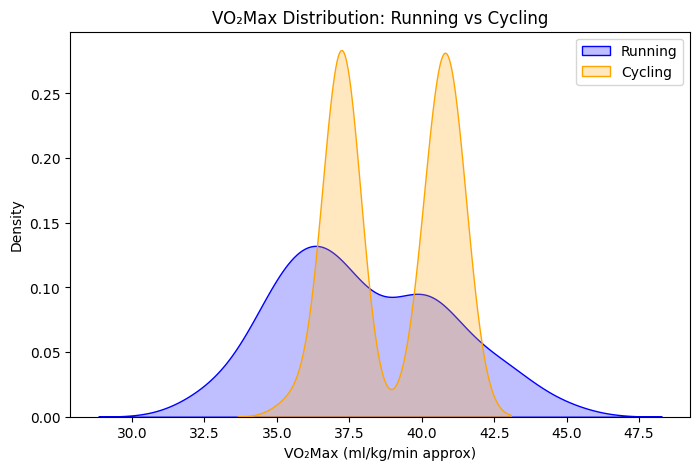

In [153]:
plt.figure(figsize=(8,5))
sns.kdeplot(df_running['VO2max_est'], label="Running", fill=True, color="blue")
sns.kdeplot(df_cycling['VO2max_est'], label="Cycling", fill=True, color="orange")
plt.title("VO₂Max Distribution: Running vs Cycling")
plt.xlabel("VO₂Max (ml/kg/min approx)")
plt.legend()
plt.show()